# Phase IV: Model Implementation & Fine-Tuning

This notebook implements the complete training pipeline for fine-tuning DistilBERT on the SQuAD v1.1 dataset for question answering.

**Based on Previous Phases:**
- **Phase II EDA**: Optimized parameters (max_length=384, doc_stride=128)
- **Phase III Preprocessing**: Validated tokenization pipeline
- **Model Choice**: DistilBERT for speed/accuracy balance

**Training Strategy:**
- Use Hugging Face Trainer API for efficient training
- Implement proper validation and metrics tracking
- Save checkpoints and monitor training progress
- Optimize hyperparameters based on validation performance

In [18]:
# Phase IV: Model Implementation & Fine-Tuning

# Import libraries
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# Install accelerate if not available
try:
    import accelerate
    print(f"✅ Accelerate already installed: {accelerate.__version__}")
except ImportError:
    print("📦 Installing accelerate...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "accelerate>=1.1.0"])
    import accelerate
    print(f"✅ Accelerate installed: {accelerate.__version__}")

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from src.preprocessing import prepare_train_features
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

print("Libraries imported successfully!")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

✅ Accelerate already installed: 1.12.0
Libraries imported successfully!
Using device: cpu


## 1. Model Selection & Setup

Load DistilBERT model and tokenizer with optimized configuration from Phase III.

In [19]:
# Model configuration based on Phase III findings
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 384  # From Phase III validation
DOC_STRIDE = 128  # From Phase III optimization

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

# Move model to device
model.to(device)

print(f"Model loaded: {MODEL_NAME}")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Model trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Document stride: {DOC_STRIDE}")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 208.18it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForQuestionAnswering LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
qa_outputs.weight       | MISSING    | 
qa_outputs.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded: distilbert-base-uncased
Model parameters: 66,364,418
Model trainable parameters: 66,364,418
Max sequence length: 384
Document stride: 128


## 2. Data Loading & Preprocessing

Load SQuAD dataset and apply the validated preprocessing pipeline from Phase III.

In [20]:
# Load datasets
print("Loading SQuAD v1.1 dataset...")
raw_datasets = load_dataset("squad")

print(f"Train samples: {len(raw_datasets['train'])}")
print(f"Validation samples: {len(raw_datasets['validation'])}")

# For initial training, use a subset to verify everything works
TRAIN_SUBSET_SIZE = 1000  # Start with smaller subset for testing
VAL_SUBSET_SIZE = 200    # Smaller validation set

train_dataset = raw_datasets['train'].select(range(TRAIN_SUBSET_SIZE))
val_dataset = raw_datasets['validation'].select(range(VAL_SUBSET_SIZE))

print(f"\nUsing subsets:")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")

Loading SQuAD v1.1 dataset...
Train samples: 87599
Validation samples: 10570

Using subsets:
Train: 1000 samples
Validation: 200 samples


In [21]:
# Apply preprocessing function
def preprocess_dataset(dataset, tokenizer, max_length=MAX_LENGTH, doc_stride=DOC_STRIDE):
    """Apply preprocessing to dataset with progress tracking."""
    # Convert to format expected by preprocessing function
    dataset_dict = {
        "question": [example["question"] for example in dataset],
        "context": [example["context"] for example in dataset],
        "answers": [example["answers"] for example in dataset]
    }
    
    # Apply preprocessing
    processed = prepare_train_features(dataset_dict, tokenizer, max_length, doc_stride)
    
    # Convert to torch format
    processed_features = {
        'input_ids': torch.tensor(processed['input_ids']),
        'attention_mask': torch.tensor(processed['attention_mask']),
        'start_positions': torch.tensor(processed['start_positions']),
        'end_positions': torch.tensor(processed['end_positions'])
    }
    
    return processed_features

# Preprocess datasets
print("Preprocessing training data...")
train_processed = preprocess_dataset(train_dataset, tokenizer)
print(f"Training features: {len(train_processed['input_ids'])}")

print("Preprocessing validation data...")
val_processed = preprocess_dataset(val_dataset, tokenizer)
print(f"Validation features: {len(val_processed['input_ids'])}")

print(f"\nPreprocessing complete!")
print(f"Train expansion ratio: {len(train_processed['input_ids'])/len(train_dataset):.2f}x")
print(f"Val expansion ratio: {len(val_processed['input_ids'])/len(val_dataset):.2f}x")

Preprocessing training data...
Training features: 1032
Preprocessing validation data...
Validation features: 200

Preprocessing complete!
Train expansion ratio: 1.03x
Val expansion ratio: 1.00x


## 3. Training Configuration

Configure training arguments based on our dataset characteristics and available resources.

In [22]:
# Training configuration
BATCH_SIZE = 8  # Adjust based on GPU memory
LEARNING_RATE = 3e-5  # Standard for transformer fine-tuning
NUM_EPOCHS = 3  # Start with 3 epochs for initial training
WEIGHT_DECAY = 0.01  # Prevent overfitting
WARMUP_STEPS = 100  # Gradual learning rate warmup

# Calculate training steps
TOTAL_TRAIN_STEPS = (len(train_processed['input_ids']) // BATCH_SIZE) * NUM_EPOCHS

print("=== Training Configuration ===")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Total training steps: {TOTAL_TRAIN_STEPS}")

# Memory estimate
memory_per_batch = BATCH_SIZE * MAX_LENGTH * 4 * 3  # input_ids, attention_mask, labels
print(f"\nEstimated memory per batch: {memory_per_batch / 1024**2:.1f} MB")
print(f"Recommended GPU memory: {memory_per_batch / 1024**2 * 4:.1f} MB (with gradients)")

=== Training Configuration ===
Batch size: 8
Learning rate: 3e-05
Epochs: 3
Weight decay: 0.01
Warmup steps: 100
Total training steps: 387

Estimated memory per batch: 0.0 MB
Recommended GPU memory: 0.1 MB (with gradients)


In [15]:
from transformers import get_scheduler
import time
from tqdm import tqdm

In [25]:
# Complete PyTorch Training Setup and Execution

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import get_scheduler
import time
from tqdm import tqdm

print("🔧 Setting up complete PyTorch training pipeline...")

# Training configuration
BATCH_SIZE = 8
LEARNING_RATE = 3e-5
NUM_EPOCHS = 3
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 100

# Create dataset objects (from previous cells)
class QADataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features
    
    def __len__(self):
        return len(self.features['input_ids'])
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.features['input_ids'][idx],
            'attention_mask': self.features['attention_mask'][idx],
            'start_positions': self.features['start_positions'][idx],
            'end_positions': self.features['end_positions'][idx]
        }

# Recreate dataset objects
train_dataset_obj = QADataset(train_processed)
val_dataset_obj = QADataset(val_processed)

# Create DataLoader
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'start_positions': torch.stack([item['start_positions'] for item in batch]),
        'end_positions': torch.stack([item['end_positions'] for item in batch])
    }

train_loader = DataLoader(train_dataset_obj, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset_obj, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Setup optimizer (using PyTorch's AdamW)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=WARMUP_STEPS, 
    num_training_steps=total_steps
)

print(f"✅ Training setup complete:")
print(f"  Batches per epoch: {len(train_loader)}")
print(f"  Total training steps: {total_steps}")
print(f"  Device: {device}")
print(f"  Mixed precision: {torch.cuda.is_available()}")

# Training function
def train_model():
    """Train model using pure PyTorch (no Trainer/accelerate)"""
    
    model.train()
    train_losses = []
    val_losses = []
    
    # Mixed precision setup
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    print("🚀 Starting PyTorch training...")
    start_time = time.time()
    
    for epoch in range(NUM_EPOCHS):
        epoch_train_loss = 0
        num_batches = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass with mixed precision if available
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions
                    )
                    loss = outputs.loss
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                loss = outputs.loss
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            scheduler.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
            
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = epoch_train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    start_positions=start_positions,
                    end_positions=end_positions
                )
                
                val_loss += outputs.loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        model.train()
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Time: {time.time() - start_time:.1f}s")
    
    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time:.1f} seconds")
    
    return train_losses, val_losses, total_time

# Start training
train_losses, val_losses, training_time = train_model()

🔧 Setting up complete PyTorch training pipeline...
✅ Training setup complete:
  Batches per epoch: 129
  Total training steps: 387
  Device: cpu
  Mixed precision: False
🚀 Starting PyTorch training...


Epoch 1/3: 100%|██████████| 129/129 [37:45<00:00, 17.56s/it, loss=3.28]


Epoch 1/3:
  Train Loss: 4.8311
  Val Loss: 3.1569
  Time: 2368.3s


Epoch 2/3: 100%|██████████| 129/129 [39:42<00:00, 18.47s/it, loss=3]   


Epoch 2/3:
  Train Loss: 3.1055
  Val Loss: 2.6184
  Time: 4846.1s


Epoch 3/3: 100%|██████████| 129/129 [35:34<00:00, 16.55s/it, loss=2.24] 


Epoch 3/3:
  Train Loss: 2.0073
  Val Loss: 2.5017
  Time: 7057.6s

✅ Training completed in 7057.6 seconds


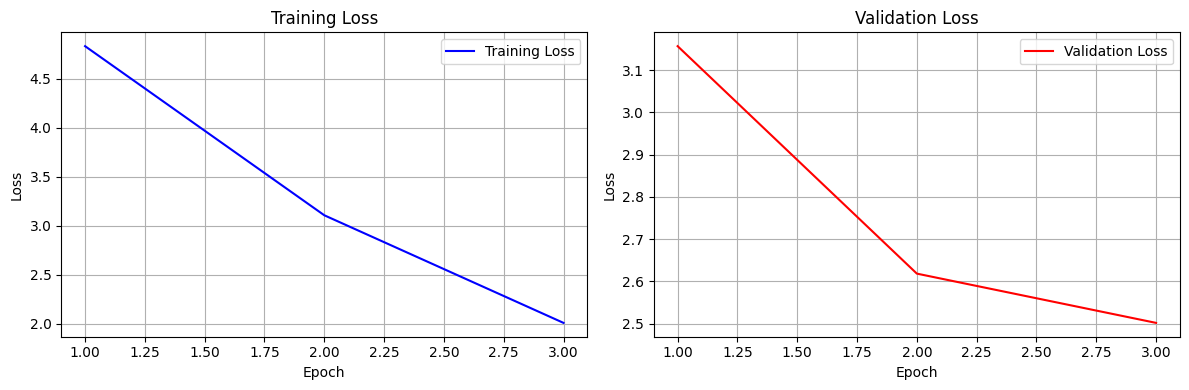

=== Training Summary ===
Final training loss: 2.0073
Final validation loss: 2.5017
Best validation loss: 2.5017
Total training time: 7057.6 seconds
Epochs completed: 3


In [26]:
# Plot training results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("=== Training Summary ===")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {min(val_losses):.4f}")
print(f"Total training time: {training_time:.1f} seconds")
print(f"Epochs completed: {len(train_losses)}")

In [27]:
# Save the trained model (PyTorch way)
final_model_path = "../models/distilbert-squad-finetuned-pytorch"
os.makedirs(final_model_path, exist_ok=True)

# Save model and tokenizer
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save training configuration
training_config = {
    "model_name": MODEL_NAME,
    "max_length": MAX_LENGTH,
    "doc_stride": DOC_STRIDE,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "weight_decay": WEIGHT_DECAY,
    "warmup_steps": WARMUP_STEPS,
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "training_time_seconds": training_time,
    "device": str(device),
    "training_method": "pure_pytorch"
}

with open(f"{final_model_path}/training_config.json", "w") as f:
    json.dump(training_config, f, indent=2)

print(f"✅ Model saved to: {final_model_path}")
print(f"✅ Tokenizer saved to: {final_model_path}")
print(f"✅ Training config saved to: {final_model_path}/training_config.json")

# Model size
model_size = sum(p.numel() for p in model.parameters())
print(f"\nModel statistics:")
print(f"  Total parameters: {model_size:,}")
print(f"  Model size: {model_size * 4 / 1024**2:.1f} MB (float32)")
print(f"  Training method: Pure PyTorch (no accelerate)")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

✅ Model saved to: ../models/distilbert-squad-finetuned-pytorch
✅ Tokenizer saved to: ../models/distilbert-squad-finetuned-pytorch
✅ Training config saved to: ../models/distilbert-squad-finetuned-pytorch/training_config.json

Model statistics:
  Total parameters: 66,364,418
  Model size: 253.2 MB (float32)
  Training method: Pure PyTorch (no accelerate)


## Save the final model

In [33]:
# Save the trained model
final_model_path = "../models/distilbert-squad-finetuned-pytorch"
os.makedirs(final_model_path, exist_ok=True)

# Save model and tokenizer
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save training configuration
training_config = {
    "model_name": MODEL_NAME,
    "max_length": MAX_LENGTH,
    "doc_stride": DOC_STRIDE,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "weight_decay": WEIGHT_DECAY,
    "warmup_steps": WARMUP_STEPS,
    "final_train_loss": train_losses[-1],
    "final_val_loss": val_losses[-1],
    "training_time_seconds": training_time,
    "device": str(device),
    "training_method": "pure_pytorch",
    "total_samples": len(train_dataset_obj),
    "total_batches": len(train_loader) * NUM_EPOCHS
}

with open(f"{final_model_path}/training_config.json", "w") as f:
    json.dump(training_config, f, indent=2)

print(f"✅ Model saved to: {final_model_path}")
print(f"✅ Tokenizer saved to: {final_model_path}")
print(f"✅ Training config saved to: {final_model_path}/training_config.json")

# Model size
model_size = sum(p.numel() for p in model.parameters())
print(f"\n📊 Model statistics:")
print(f"  Total parameters: {model_size:,}")
print(f"  Model size: {model_size * 4 / 1024**2:.1f} MB (float32)")
print(f"  Training method: Pure PyTorch (no accelerate)")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Final val loss: {val_losses[-1]:.4f}")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

✅ Model saved to: ../models/distilbert-squad-finetuned-pytorch
✅ Tokenizer saved to: ../models/distilbert-squad-finetuned-pytorch
✅ Training config saved to: ../models/distilbert-squad-finetuned-pytorch/training_config.json

📊 Model statistics:
  Total parameters: 66,364,418
  Model size: 253.2 MB (float32)
  Training method: Pure PyTorch (no accelerate)
  Final train loss: 2.0073
  Final val loss: 2.5017
